<a href="https://colab.research.google.com/github/wangjh789/2021-2_BigData/blob/master/set_similarity_join.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/gohdong/2021_autumn/master/BigData/project1/facebook_combined.txt 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install findspark
!pip install pyspark
!pip install numpy

--2021-10-08 03:30:44--  https://raw.githubusercontent.com/gohdong/2021_autumn/master/BigData/project1/facebook_combined.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 854362 (834K) [text/plain]
Saving to: ‘facebook_combined.txt’

facebook_combined.t 100%[===================>] 834.34K  --.-KB/s    in 0.05s   

2021-10-08 03:30:44 (16.8 MB/s) - ‘facebook_combined.txt’ saved [854362/854362]

--2021-10-08 03:31:00--  https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224445805 (214M) [application/x-gzip]
Saving to: ‘spark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

import findspark
import time
findspark.init()
from pyspark import SparkContext


sc = SparkContext("local","similarity_join")

In [3]:
undirect = sc.textFile('facebook_combined.txt').map(lambda x : x.split(" "))\
.flatMap(lambda x: ((int(x[0]),int(x[1])),(int(x[1]),int(x[0])))).groupByKey().mapValues(list)


ref = sc.broadcast(dict(undirect.collect()))

In [4]:
def brute_force(threshold):

    def make_invert(item):
      key= item[0]
      arr = item[1]
      result = []
      for i in arr:
          result.append((i,key))
      return result

    def make_pairs(item):
      result = []
      arr = item[1]
      for idx,i in enumerate(arr):
          for j in arr[idx+1:]:
              result.append(((i,j),1))
      return result
      
    def verify(item):
      x = item[0][0]
      y = item[0][1]
      overlap = item[1]
      a = threshold/(1+threshold)*(len(ref.value[x])+len(ref.value[y]))
      return overlap >= a
    
    def is_not_friend(item):
      x = item[0][0]
      y = item[0][1]
      target,arr = x,ref.value[y]
      return not (target in arr)

    start = time.time()

    ref = sc.broadcast(dict(undirect.collect()))
    
    sort_end = time.time() #sort 종료

    invert = undirect.flatMap(make_invert).groupByKey().mapValues(list)
    pairs = invert.flatMap(make_pairs).reduceByKey(lambda x,y : x+y)
    num_pairs = pairs.count()

    candidate_end = time.time() # 후보쌍 생성 종료

    result = pairs.filter(verify).filter(is_not_friend).flatMap(lambda x: ((x[0][0],x[0][1]),(x[0][1],x[0][0])))
    num_result = result.count()

    verify_end = time.time() # verify 종료
    return num_pairs, num_result,start,sort_end,candidate_end,verify_end

In [5]:
def all_pairs(threshold):

  def make_invert(item):
    key = item[0]
    arr= item[1]
    result= []
    prefix_len = int(len(ref.value[key]) - threshold*len(ref.value[key]) + 1) #prefix_filtering 
    for i in arr[:prefix_len]:
      result.append((i,key))
    return result

  def make_pair(item):
    arr = item[1]
    result = []
    for idx,i in enumerate(arr):
        for j in arr[idx+1:]:
          if not len(ref.value[j]) >= threshold*len(ref.value[i]): continue #size filtering |x| >= t * |y| 
          result.append(((i,j),1))
    return result

  def verify(item):
    x = item[0][0]
    y = item[0][1]

    value = len(list(set(ref.value[x])&set(ref.value[y]))) / len(list(set(ref.value[x])|set(ref.value[y])))
    return threshold <= value

  def is_not_friend(item):
    x = item[0][0]
    y = item[0][1]
    target,arr = x,ref.value[y]
    return not (target in arr)

  start = time.time()

  A =undirect.map(lambda x: len(x[1])).collect()
  B=sorted(range(len(A)),key=lambda x:A[x])
  order=sorted(range(len(A)),key=lambda x:B[x])
  sorted_undirect = undirect.mapValues(lambda x: sorted(x, key=lambda y : order[y]))

  ref = sc.broadcast(dict(sorted_undirect.collect()))

  sort_end = time.time() #sort 종료

  invert = sorted_undirect.flatMap(make_invert).groupByKey().mapValues(list)
  pairs = invert.flatMap(make_pair).reduceByKey(lambda x,y : x+y)
  num_pairs = pairs.count()

  candidate_end = time.time() # 후보쌍 생성 종료

  result = pairs.filter(verify).filter(is_not_friend).flatMap(lambda x: ((x[0][0],x[0][1]),(x[0][1],x[0][0])))
  num_result = result.count()

  verify_end = time.time() # verify 종료

  return num_pairs, num_result,start,sort_end,candidate_end,verify_end

In [6]:
def pp_join(threshold):

  def make_pair(item):
    arr = item[1]
    result = []
    for idx,i in enumerate(arr):
        for j in arr[idx+1:]:
          if not len(ref.value[j]) >= threshold*len(ref.value[i]): continue
          result.append(((i,j),1))
    return result

  def make_invert(item): 
    key = item[0]
    arr= item[1]
    result= []
    prefix_len = int(len(ref.value[key]) - threshold*len(ref.value[key]) + 1) 
    for i in arr[:prefix_len]:
      result.append((i,key))
    return result

  def verify(item):
    x,y = item[0][0],item[0][1]

    Px = int(len(ref.value[x]) - threshold*len(ref.value[x]) + 1)
    Py = int(len(ref.value[y]) - threshold*len(ref.value[y]) + 1)

    Wx = ref.value[x][Px-1] 
    Wy = ref.value[y][Py-1]

    share = item[1]  #x,y의 prefix 에서의 Overlap 수

    a = threshold/(1+threshold)*(len(ref.value[x])+len(ref.value[y]))
    value = 0
    
    if order[Wx] < order[Wy]:                          
      value = share + len(set(ref.value[x][Px:])&set(ref.value[y][share:])) 

    else :                                             
      value = share + len(set(ref.value[x][share:])&set(ref.value[y][Py:]))

    return value >= a

  def is_not_friend(item):
    x = item[0][0]
    y = item[0][1]
    target,arr = x,ref.value[y]
    return not (target in arr)


  start = time.time()

  A =undirect.map(lambda x: len(x[1])).collect()
  B=sorted(range(len(A)),key=lambda x:A[x])
  order=sorted(range(len(A)),key=lambda x:B[x])
  sorted_undirect = undirect.mapValues(lambda x: sorted(x, key=lambda y : order[y]))

  ref = sc.broadcast(dict(sorted_undirect.collect()))

  sort_end = time.time() #sort 종료

  invert = sorted_undirect.flatMap(make_invert).groupByKey().mapValues(list)
  pairs = invert.flatMap(make_pair).reduceByKey(lambda x,y : x+y)
  num_pairs = pairs.count()

  candidate_end = time.time() # 후보쌍 생성 종료

  result = pairs.filter(verify).filter(is_not_friend).flatMap(lambda x: ((x[0][0],x[0][1]),(x[0][1],x[0][0])))
  num_result = result.count()

  verify_end = time.time() # verify 종료

  return num_pairs, num_result,start,sort_end,candidate_end,verify_end

In [7]:
import numpy

t = numpy.arange(0.1, 1, 0.1)
brute = []
all = []
pp = []

#threshold에 따른 return 값 배열에 담기
for threshold in t:
  brute.append(brute_force(threshold))
  all.append(all_pairs(threshold))
  pp.append(pp_join(threshold))




In [8]:
brute_total = list(zip(*brute))
all_total = list(zip(*all))
pp_total = list(zip(*pp))

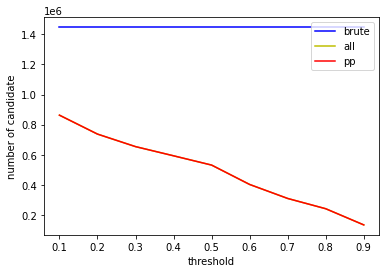

In [9]:
import matplotlib.pyplot as plt


brute_n_pair = brute_total[0]
all_n_pair = all_total[0]
pp_n_pair = pp_total[0]

plt.plot(t,brute_n_pair,'b',label='brute')
plt.plot(t,all_n_pair,'y',label='all')
plt.plot(t,pp_n_pair,'r',label='pp')
plt.legend(loc='upper right')
plt.ylabel('number of candidate')
plt.xlabel("threshold")
plt.show()
#threshold 에 따른 발생하는 후보쌍의 개수
#brute는 필터링을 하지 않아 threshold에 무관하게 일정
#all , pp 는 동일하게 length, prefix 필터링을 거쳐 발생하는 후보쌍 수가 서로 동일함

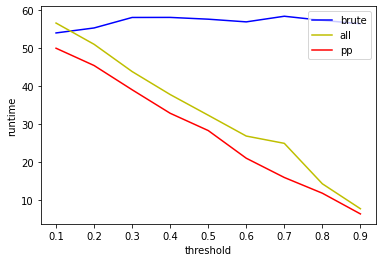

In [10]:
brute_time = [i-j for i,j in zip(brute_total[5],brute_total[2])]
all_time = [i-j for i,j in zip(all_total[5],all_total[2])]
pp_time = [i-j for i,j in zip(pp_total[5],pp_total[2])]

plt.plot(t,brute_time,'b',label='brute')
plt.plot(t,all_time,'y',label='all')
plt.plot(t,pp_time,'r',label='pp')
plt.legend(loc='upper right')
plt.ylabel('runtime')
plt.xlabel("threshold")
plt.show()

#threshold 에 따른 전체 실행속도

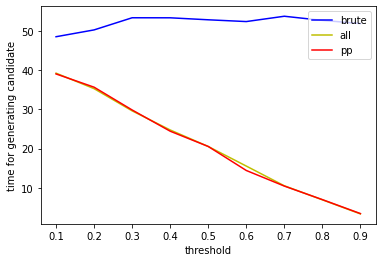

In [12]:
brute_cand = [i-j for i,j in zip(brute_total[4],brute_total[3])]
all_cand = [i-j for i,j in zip(all_total[4],all_total[3])]
pp_cand = [i-j for i,j in zip(pp_total[4],pp_total[3])]

plt.plot(t,brute_cand,'b',label='brute')
plt.plot(t,all_cand,'y',label='all')
plt.plot(t,pp_cand,'r',label='pp')
plt.legend(loc='upper right')
plt.ylabel('time for generating candidate')
plt.xlabel("threshold")
plt.show()

#threshold에 따른 후보쌍을 생성하는데 소요되는 시간
#brute는 필터링을 거치지 않아 threshold와 무관하게 거의 일정하다.
#pp,all은 필터링을 거쳐 threshold에 따라 후보쌍의 개수와 생성 시간이 감소된다.

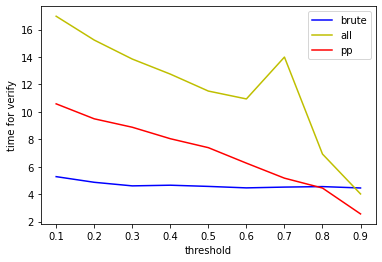

In [13]:
brute_verify = [i-j for i,j in zip(brute_total[5],brute_total[4])]
all_verify  = [i-j for i,j in zip(all_total[5],all_total[4])]
pp_verify  = [i-j for i,j in zip(pp_total[5],pp_total[4])]

plt.plot(t,brute_verify,'b',label='brute')
plt.plot(t,all_verify,'y',label='all')
plt.plot(t,pp_verify,'r',label='pp')
plt.legend(loc='upper right')
plt.ylabel('time for verify')
plt.xlabel("threshold")
plt.show()

#threshold에 따른 후보쌍을 판별하는데 소요되는 시간
#brute는 필터링을 거치지 않아 후보쌍의 개수가 일정해 판별시간 또한 일정하다. brute: treshold 계산 O(1) / pp,all : 교집합 계산 O(n)
#pp, all은 필터링을 거쳐 threshold에 따라 후보쌍의 개수와 판별시간이 감소한다.

#pp 는 all보다 추가로 positional imformation 을 이용하므로 all보다 판별 시간이 적게 소요된다.